In [1]:
pwd

'/Users/in-divye.singh/Documents/Projects/MIC_predictor/notebooks/classifier'

In [2]:
cd ../../

/Users/in-divye.singh/Documents/Projects/MIC_predictor


In [3]:
from notebooks.utils import *

In [20]:
import biovec
import numpy as np
import pandas as pd
from itertools import chain
from collections import Counter

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

In [95]:
from sklearn.svm import SVC
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, matthews_corrcoef
from sklearn.metrics import classification_report, confusion_matrix, make_scorer
from sklearn.model_selection import train_test_split

In [7]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [64]:
avp_ic50 = pd.read_csv("data/raw/AVP-IC50Pred_train.csv")
ha_avp = pd.read_csv("data/raw/HA_AVP.csv")

df = pd.concat([avp_ic50[['Sequence','MIC']], ha_avp], axis=0).drop_duplicates(['Sequence']).reset_index(drop=True)
df = sequence_filtering(df)

In [65]:
df['lessthan5'] = df['MIC'].apply(lambda mic: 1 if mic <= 5 else 0)

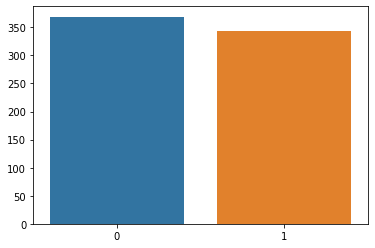

In [66]:
count = dict(Counter(df['lessthan5']))
sns.barplot(x = [str(k) for k in count.keys()], y=[float(v) for v in count.values()])

In [78]:
def get_score(y_true, y_pred):
    print(f'Accuracy: {round(accuracy_score(y_true, y_pred), 4)}')
    print(f'F1-score: {round(f1_score(y_true, y_pred), 4)}')
    print(f'AUROC: {round(roc_auc_score(y_true, y_pred), 4)}')
    print(f'MCC: {round(matthews_corrcoef(y_true, y_pred), 4)}')
    print(classification_report(y_test, y_pred))

### AA frequency

In [13]:
aa_freq = reduce_by_kmer_frequency(df)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(aa_freq, df['lessthan5'], test_size=0.2, random_state=42)

In [16]:
X_train.shape, X_test.shape

((569, 20), (143, 20))

In [73]:
rf = RandomForestClassifier(class_weight="balanced")

In [74]:
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced')

In [79]:
y_pred = rf.predict(X_test)

In [80]:
get_score(y_test, y_pred)

Accuracy: 0.7133
F1-score: 0.687
AUROC: 0.7184
MCC: 0.4311
              precision    recall  f1-score   support

           0       0.79      0.69      0.74        83
           1       0.63      0.75      0.69        60

    accuracy                           0.71       143
   macro avg       0.71      0.72      0.71       143
weighted avg       0.73      0.71      0.72       143



### Dipeptide frequency

In [81]:
dipep_freq = reduce_by_kmer_frequency(df, kmer=2)

In [82]:
X_train, X_test, y_train, y_test = train_test_split(dipep_freq, df['lessthan5'], test_size=0.2, random_state=42)

In [83]:
X_train.shape, X_test.shape

((569, 400), (143, 400))

In [84]:
rf = RandomForestClassifier(class_weight="balanced")

In [85]:
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced')

In [86]:
y_pred = rf.predict(X_test)

In [87]:
get_score(y_test, y_pred)

Accuracy: 0.7413
F1-score: 0.6992
AUROC: 0.7379
MCC: 0.4729
              precision    recall  f1-score   support

           0       0.79      0.76      0.77        83
           1       0.68      0.72      0.70        60

    accuracy                           0.74       143
   macro avg       0.74      0.74      0.74       143
weighted avg       0.74      0.74      0.74       143



### AA freq + dipep freq

In [88]:
aa_dipep_freq = pd.concat([aa_freq, dipep_freq], axis=1)

In [89]:
X_train, X_test, y_train, y_test = train_test_split(aa_dipep_freq, df['lessthan5'], test_size=0.2, random_state=42)

In [90]:
X_train.shape, X_test.shape

((569, 420), (143, 420))

In [91]:
rf = RandomForestClassifier(class_weight="balanced")

In [92]:
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced')

In [93]:
y_pred = rf.predict(X_test)

In [94]:
get_score(y_test, y_pred)

Accuracy: 0.7552
F1-score: 0.7154
AUROC: 0.7522
MCC: 0.5014
              precision    recall  f1-score   support

           0       0.80      0.77      0.79        83
           1       0.70      0.73      0.72        60

    accuracy                           0.76       143
   macro avg       0.75      0.75      0.75       143
weighted avg       0.76      0.76      0.76       143



### Hyperparameter tuning

In [96]:
mcc_scorer = make_scorer(matthews_corrcoef)

In [101]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [None, 80, 90, 100, 110],
    'max_features': ['auto', 2, 3],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'min_samples_split': [2, 8, 10, 12],
    'n_estimators': [100, 200, 300, 500]
}
# Create a based model
rf = RandomForestClassifier(class_weight="balanced")
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 1, scoring=mcc_scorer)

In [102]:
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 1200 candidates, totalling 3600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   35.7s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 3600 out of 3600 | elapsed:  6.9min finished


GridSearchCV(cv=3, estimator=RandomForestClassifier(class_weight='balanced'),
             n_jobs=-1,
             param_grid={'max_depth': [None, 80, 90, 100, 110],
                         'max_features': ['auto', 2, 3],
                         'min_samples_leaf': [1, 2, 3, 4, 5],
                         'min_samples_split': [2, 8, 10, 12],
                         'n_estimators': [100, 200, 300, 500]},
             scoring=make_scorer(matthews_corrcoef), verbose=1)

In [103]:
grid_search.best_params_

{'max_depth': 80,
 'max_features': 2,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 300}

In [104]:
best_grid = grid_search.best_estimator_

In [105]:
y_pred = best_grid.predict(X_test)

In [106]:
get_score(y_test, y_pred)

Accuracy: 0.7692
F1-score: 0.7317
AUROC: 0.7666
MCC: 0.5299
              precision    recall  f1-score   support

           0       0.81      0.78      0.80        83
           1       0.71      0.75      0.73        60

    accuracy                           0.77       143
   macro avg       0.76      0.77      0.76       143
weighted avg       0.77      0.77      0.77       143



### feature selection

In [175]:
from mlxtend.feature_selection import SequentialFeatureSelector

In [155]:
rf_clf = RandomForestClassifier(class_weight='balanced', max_depth=80, max_features=0.005, min_samples_leaf=1,
                                min_samples_split=10, n_estimators=300)

In [178]:
selector = SequentialFeatureSelector(rf_clf, k_features='best', forward=False, verbose=2,
                                     scoring=mcc_scorer, cv=5, n_jobs=-1)

In [179]:
selector.fit(aa_dipep_freq, df['lessthan5'])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed:  3.5min finished

[2021-02-28 17:37:11] Features: 419/1 -- score: 0.4315803053188172[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   12.5s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 419 out of 419 | elapsed:  3.9min finished

[2021-02-28 17:41:07] Features: 418/1 -- score: 0.43851886798275874[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  1.4

SequentialFeatureSelector(estimator=RandomForestClassifier(class_weight='balanced',
                                                           max_depth=80,
                                                           max_features=0.005,
                                                           min_samples_split=10,
                                                           n_estimators=300),
                          forward=False, k_features='best', n_jobs=-1,
                          scoring=make_scorer(matthews_corrcoef), verbose=2)

In [181]:
len(selector.k_feature_idx_)

409

In [149]:
aa_dipep_freq.columns[selector.support_]

Index(['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
       ...
       'YI', 'YK', 'YL', 'YN', 'YQ', 'YR', 'YS', 'YT', 'YW', 'YY'],
      dtype='object', length=383)

In [150]:
train_features_selected = selector.transform(X_train)
test_features_selected = selector.transform(X_test)

In [151]:
rf_clf = RandomForestClassifier(class_weight='balanced', **grid_search.best_params_)

In [171]:
rf_clf.fit(train_features_selected, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=80,
                       max_features=0.005, min_samples_split=10,
                       n_estimators=300)

In [172]:
y_pred = rf_clf.predict(test_features_selected)

In [173]:
get_score(y_test, y_pred)

Accuracy: 0.7692
F1-score: 0.736
AUROC: 0.7689
MCC: 0.533
              precision    recall  f1-score   support

           0       0.82      0.77      0.80        83
           1       0.71      0.77      0.74        60

    accuracy                           0.77       143
   macro avg       0.76      0.77      0.77       143
weighted avg       0.77      0.77      0.77       143

